In [65]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
import numpy as np
import re
import gensim
import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('datasets/positive.csv', sep=';', names=n)
data_negative = pd.read_csv('datasets/negative.csv', sep=';', names=n)

In [3]:
data_negative = data_negative[0:25000]
print(data_negative.shape[0])
data_negative.head()

25000


,id,date,name,text,typr,rep,rtw,faw,stcount,foll,frien,listcount
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [4]:
data_positive = data_positive[0:25000]
print(data_positive.shape[0])
data_positive.head()

25000


,id,date,name,text,typr,rep,rtw,faw,stcount,foll,frien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [5]:
data_total = pd.concat([data_negative,data_positive])
data_total.head()

,id,date,name,text,typr,rep,rtw,faw,stcount,foll,frien,listcount
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [6]:
# длина датасета
len(data_total)

50000

In [7]:
# есть ли какое-либо другое значение, кроме отрицательного и положительного?
data_total['typr'].unique()

array([-1,  1], dtype=int64)

In [8]:
# распределение набора данных
data_total.groupby('typr').nunique()

,id,date,name,text,rep,rtw,faw,stcount,foll,frien,listcount
typr,,,,,,,,,,,
-1,25000,20472,21369,23698,1,115,2,10313,2308,1795,285
1,25000,10386,21039,24307,1,212,3,10985,2708,2034,280


In [9]:
# оставляем только те столбцы, которые будут использоваться
data_total = data_total[['text','typr']]
data_total.head()

,text,typr
0,на работе был полный пиддес :| и так каждое за...,-1
1,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1
2,@elina_4post как говорят обещаного три года жд...,-1
3,"Желаю хорошего полёта и удачной посадки,я буду...",-1
4,"Обновил за каким-то лешим surf, теперь не рабо...",-1


In [10]:
# есть ли нулевое значение?
data_total["text"].isnull().sum()

0

In [11]:
# заполняем нулевые значения
data_total["text"].fillna("пусто", inplace = True)

In [12]:
# очистки текста
def depure_data(data):
    # удаляем URL
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    # удаляем Email
    data = re.sub('\S*@\S*\s?', '', data)
    # удалем симолы новой строки
    data = re.sub('\s+', ' ', data)
    # удаляем одинарные ковычки
    data = re.sub("\'", "", data)

    # приведение к нижнему регистру + замена «ё» на «е»
    # data = data.lower().replace("ё", "е")

    # замена ссылок на токен «URL»
    # data = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', data)

    # замена упоминания пользователя на токен «USER»
    # data = re.sub('@[^\s]+', 'USER', data)

    # удаление знаков пунктуации
    # data = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', data)
    # data = re.sub(' +', ' ', data)

    return data

In [13]:
temp = []
# разделение pd.Series на список
data_to_list = data_total['text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['на работе был полный пиддес :| и так каждое закрытие месяца, я же свихнусь так D:',
 'Коллеги сидят рубятся в Urban terror, а я из-за долбанной винды не могу :(',
 'как говорят обещаного три года ждут...((',
 'Желаю хорошего полёта и удачной посадки,я буду очень сильно скучать( ',
 'Обновил за каким-то лешим surf, теперь не работает простоплеер :(']

In [14]:
# удаляем повторяющиеся слова из набора данных, следуя идее, что самые короткие и длинные обычно бесполезны
# преобразование строки в список токенов.
# deacc=True удаляет знаки препинания

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['на', 'работе', 'был', 'полныи', 'пиддес', 'так', 'каждое', 'закрытие', 'месяца', 'же', 'свихнусь', 'так'], ['коллеги', 'сидят', 'рубятся', 'urban', 'terror', 'из', 'за', 'долбаннои', 'винды', 'не', 'могу'], ['как', 'говорят', 'обещаного', 'три', 'года', 'ждут'], ['желаю', 'хорошего', 'полета', 'удачнои', 'посадки', 'буду', 'очень', 'сильно', 'скучать'], ['обновил', 'за', 'каким', 'то', 'лешим', 'surf', 'теперь', 'не', 'работает', 'простоплеер'], ['котенка', 'вчера', 'носик', 'разбила', 'плакала', 'расстраивалась'], ['зашли', 'то', 'он', 'опять', 'затихарился', 'прямо', 'физически', 'страдаю', 'когда', 'он', 'долго', 'молчит'], ['вообще', 'не', 'болею', 'не', 'выздоравливаю'], ['микрофраза', 'учимся', 'срать', 'кирпичами', 'режиме', 'amp', 'quot', 'нон', 'стоп', 'amp', 'quot'], ['хочу', 'тобои', 'помириться', 'но', 'сука', 'гордая', 'никогда', 'этого', 'не', 'сделаю']]


In [15]:
len(data_words)

50000

In [16]:
# функция для детокенизации всех предложений
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [17]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['на работе был полныи пиддес так каждое закрытие месяца же свихнусь так', 'коллеги сидят рубятся urban terror из за долбаннои винды не могу', 'как говорят обещаного три года ждут', 'желаю хорошего полета удачнои посадки буду очень сильно скучать', 'обновил за каким то лешим surf теперь не работает простоплеер']


In [18]:
data = np.array(data)

In [19]:
labels = np.array(data_total['typr'])

y = []
for i in range(len(labels)):
    #negative
    if labels[i] == -1:
        y.append(0)
    #positive
    if labels[i] == 1:
        y.append(1)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 2, dtype="float32")


In [20]:
len(labels)

50000

In [21]:
# преобразование текстовых данных в двумерные данные с плавающей запятой

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  780   20   10]
 [   0    0    0 ...   16    1   59]
 [   0    0    0 ...  306  199 1863]
 ...
 [   0    0    0 ...  662 2303 3543]
 [   0    0    0 ...    4  642   20]
 [   0    0    0 ...   30  204 1148]]


In [22]:
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [23]:
# разбиение набора данных на обучающую и тестовую выборку в соотношении 4:1

#X_train, X_test, y_train, y_test = train_test_split(tweets, labels, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2, random_state=1)
print (len(X_train),len(X_test),len(y_train),len(y_test))

40000 10000 40000 10000


## RNN типа: двунаправленная LSTM

RNN обрабатывают последовательности, итерируя вдоль элементов последовательности и сохраняя информацию относительно того, что она обрабатывала до сих пор

In [24]:
# Bidirectional LTSM model

# Embedding - слой встраивания
# слой встраивания — это словарь, который связывает целочисленные индексы с плотными векторами, он возвращает 3D-тензор формы с плавающей запятой
# количество возможных токенов - max_words
# размерность встраиваний- 40

# двунаправленный слой
# максимизирует чувствительность порядка RNN: по сути, он состоит из двух RNN (LSTM или GRU), которые обрабатывают входную последовательность в одном другом направлении, чтобы окончательно объединить представления
# другими словами, один из слоев интерпретирует последовательности в хронологическом порядке, а второй — в антихронологическом порядке

# LSTM
# 20 - количество скрытых единиц внутри слоя = размерность выходного пространства
# Dropout - наиболее эффективный и наиболее часто используемый метод регуляризации для сетей и состоит из случайного отключения скрытых единиц во время обучения

# Dense
# 2 - выхода
# softmax в качестве функции активации в конечном слое

# RMSprop / Adam - оптимизатор = это просто механизм, который постоянно вычисляет градиент потерь и определяет, как двигаться против функции потерь, чтобы найти ее глобальные минимумы и, следовательно, найти лучшие параметры сети (ядро модели и веса ее смещения)
# categorical_crossentropy - функция потерь

modelBR = Sequential()
modelBR.add(layers.Embedding(max_words, 40, input_length=max_len))
modelBR.add(layers.Bidirectional(layers.LSTM(20, dropout=0.6)))
modelBR.add(layers.Dense(2, activation='softmax'))
modelBR.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', 
verbose=1, save_best_only=True, mode='auto', period=1, save_weights_only=False)
history = modelBR.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), callbacks=[checkpoint2])

Epoch 1/15
1250/1250 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.6481
Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to best_model2.hdf5
1250/1250 [==============================] - 189s 146ms/step - loss: 0.6192 - accuracy: 0.6481 - val_loss: 0.5682 - val_accuracy: 0.7000
Epoch 2/15
1250/1250 [==============================] - ETA: 0s - loss: 0.5590 - accuracy: 0.7077
Epoch 2: val_accuracy improved from 0.70000 to 0.70520, saving model to best_model2.hdf5
1250/1250 [==============================] - 194s 155ms/step - loss: 0.5590 - accuracy: 0.7077 - val_loss: 0.5594 - val_accuracy: 0.7052
Epoch 3/15
1250/1250 [==============================] - ETA: 0s - loss: 0.5434 - accuracy: 0.7218
Epoch 3: val_accuracy improved from 0.70520 to 0.71080, saving model to best_model2.hdf5
1250/1250 [==============================] - 159s 127ms/step - loss: 0.5434 - accuracy: 0.7218 - val_loss: 0.5553 - val_accuracy: 0.7108
Epoch 4/15
1250/1250 [=========

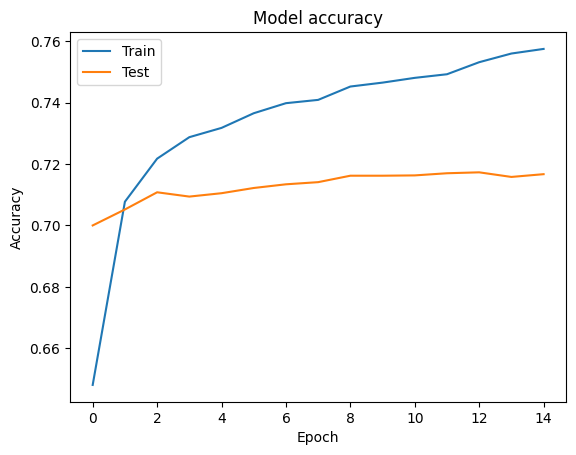

In [29]:
# график точности при обучении и валидации модели
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

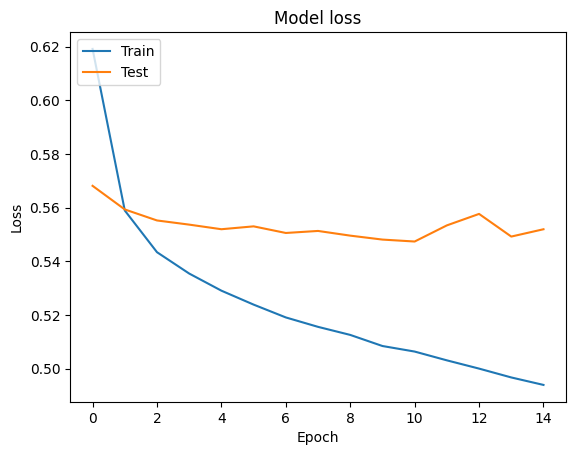

In [27]:
# график потерь при обучении и валидации модели
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [140]:
# Single LSTM layer model
# одна модель LSTM (долговременная кратковременная память)

# modelSR = Sequential()
# modelSR.add(layers.Embedding(max_words, 20))
# modelSR.add(layers.LSTM(15, dropout=0.5))
# modelSR.add(layers.Dense(2, activation='softmax'))


# modelSR.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

# checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1, save_weights_only=False)
# history = modelSR.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test),callbacks=[checkpoint1])

In [32]:
# best_model = keras.models.load_model("best_model2.hdf5")
best_model = modelBR

In [33]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

313/313 - 11s - loss: 0.5520 - accuracy: 0.7167 - 11s/epoch - 35ms/step
Model accuracy:  0.71670001745224


In [34]:
def NetWork(text):
    sentiment = ['Негативный','Позитивный']
    sequence = tokenizer.texts_to_sequences([text])
    test = pad_sequences(sequence, maxlen=max_len)
    predict = best_model.predict(test)
    print("Вероятность того, что отзыв позитивный:  {:.2f}%".format(predict[0][1] * 100))
    print("Вероятность того, что отзыв негативный:  {:.2f}%".format(predict[0][0] * 100))
    print(sentiment[np.around(predict, decimals=0).argmax(axis=1)[0]])

In [87]:
def addRowToDF(newRow, df) -> DataFrame:
    df = pd.concat([newRow, df.loc[:]]).reset_index(drop=True)
    return df

In [138]:
df2 = pd.DataFrame(columns=['text', 'perc_positive', 'perc_negative', 'predicted', 'expected', 'match'])
df2 = addRowToDF(pd.DataFrame({'text':'я так рад за тебя', 'expected':'Позитивный'}, index=[0]), df2)
df2 = addRowToDF(pd.DataFrame({'text':'какой ужасный день', 'expected':'Негативный'}, index=[0]), df2)
df2 = addRowToDF(pd.DataFrame({'text':'какой прекрасный день', 'expected':'Позитивный'}, index=[0]), df2)
df2 = addRowToDF(pd.DataFrame({'text':'ты сегодня очень плохо выглядешь', 'expected':'Негативный'}, index=[0]), df2)
df2 = addRowToDF(pd.DataFrame({'text':'платье, которое ты надела, выглядет плохо', 'expected':'Негативный'}, index=[0]), df2)
df2 = addRowToDF(pd.DataFrame({'text':'от тебя очень плохо пахнет', 'expected':'Негативный'}, index=[0]), df2)
df2 = addRowToDF(pd.DataFrame({'text':'я думаю, нам пора расстаться', 'expected':'Негативный'}, index=[0]), df2)
df2 = addRowToDF(pd.DataFrame({'text':'сегодня какой-то нехороший день у меня', 'expected':'Негативный'}, index=[0]), df2)
df2 = addRowToDF(pd.DataFrame({'text':'Как понизить температуру ноута?', 'expected':'Негативный'}, index=[0]), df2)
df2 = addRowToDF(pd.DataFrame({'text':'сегодня будет зачет по нейронным сетям', 'expected':'Негативный'}, index=[0]), df2)
df2 = addRowToDF(pd.DataFrame({'text':'моя нейронная сеть не обучается', 'expected':'Негативный'}, index=[0]), df2)
df2 = addRowToDF(pd.DataFrame({'text':'моя нейронная сеть успешно обучится', 'expected':'Позитивный'}, index=[0]), df2)

for index, row in data_negative.loc[24995:25000].iterrows():
    df2 = addRowToDF(pd.DataFrame({'text':row['text'], 'expected':'Негативный'}, index=[0]), df2)

for index, row in data_positive.loc[24995:25000].iterrows():
    df2 = addRowToDF(pd.DataFrame({'text':row['text'], 'expected':'Позитивный'}, index=[0]), df2)

In [139]:
for index, row in df2.iterrows():
    sentiment = ['Негативный','Позитивный']
    sequence = tokenizer.texts_to_sequences([row['text']])
    test = pad_sequences(sequence, maxlen=max_len)
    predict = best_model.predict(test)
    row['perc_positive'] = "{:.2f}%".format(predict[0][1] * 100)
    row['perc_negative'] = "{:.2f}%".format(predict[0][0] * 100)
    row['predicted'] = sentiment[np.around(predict, decimals=0).argmax(axis=1)[0]]
    match = A = 'yes' if row['predicted'] == row['expected'] else 'no'
    row['match'] = match

1/1 [==============================] - 0s 60ms/step


In [137]:
df2

,text,expected,perc_positive,perc_negative,predicted,match
0,"RT @hakacymipo: Ну вот он, первый пост в жабби...",Позитивный,60.62%,39.38%,Позитивный,yes
1,@sky_violett взяла поцеловала;-) Потом пощечин...,Позитивный,92.47%,7.53%,Позитивный,yes
2,Добро-недоброе утро :) А где-то происходит зак...,Позитивный,54.39%,45.61%,Позитивный,yes
3,"@alimansarov в общем, что-то ненужное явно ока...",Позитивный,54.25%,45.75%,Позитивный,yes
4,@SFGO76 @marina_saniram Добрейшего и совестлив...,Позитивный,58.60%,41.40%,Позитивный,yes
5,Ездили в триумф и в хэппимол - купили только о...,Негативный,4.82%,95.18%,Негативный,yes
6,RT @AlexMaslo13: @gbeautifulbitch прости(\nя с...,Негативный,9.02%,90.98%,Негативный,yes
7,Завтра понедельник...( и хрен ты опять выспишься(,Негативный,5.44%,94.56%,Негативный,yes
8,"RT @tzykina: омг\nмалыш, тоскливо ковыряя лопа...",Негативный,8.48%,91.52%,Негативный,yes
9,...а теперь возвращаюсь снова к работе...(( ht...,Негативный,18.46%,81.54%,Негативный,yes


In [60]:
NetWork('сегодня ясный день')

1/1 [==============================] - 0s 42ms/step
Вероятность того, что отзыв позитивный:  39.91%
Вероятность того, что отзыв негативный:  60.09%
Негативный
